# Main script to Join Data on Instrument 2 Fire Location

Modules: N/A <br>
Author: Jordan Meyer <br>
Email: jordan.meyer@berkeley.edu <br>
Date created: Feb 18, 2023 <br>

**Citations (data sources)**


**Citations (persons)**
1. Cornelia Ilin 

**Preferred environment**
1. Code written in Jupyter Notebooks

### Step 1: Import packages

In [1]:
# !pip install geopandas --quiet


In [5]:
import calendar
import os
from datetime import date, timedelta

# import cartopy.crs as ccrs
# import contextily as ctx
# import fiona
# import netCDF4 as ncdf
# import osmnx as ox
# from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# geography
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import sys
import torch as t
import statsmodels.api as sm

# Moved from sklearn.neighbors to sklearn.metrics following their package change
import sklearn.metrics

import shapely
from shapely.geometry import Point

dist = sklearn.metrics.DistanceMetric.get_metric("haversine")

# ignore warnings
import warnings

from tqdm.notebook import tqdm, trange

warnings.filterwarnings("ignore")

### Step 2: Define working directories

In [22]:
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    in_dir = '/content/drive/MyDrive/capstone_fire/data/'
    in_instrument = '/content/drive/MyDrive/capstone_fire/notebooks/instrument_2/'
    import drive.MyDrive.capstone_fire.modules.deep_ols as deep_ols
else:
    in_dir = in_instrument = "../data/instrument_2/"
    %cd '..'
    import modules.deep_ols as deep_ols
    %cd 'notebooks'
    

/Users/jordan/Documents/GitHub/fire_capstone
/Users/jordan/Documents/GitHub/fire_capstone/notebooks


In [23]:
data = pd.read_csv(in_instrument + 'non_agg_instrument.csv',index_col=0)
data.head()

,ZCTA,fire_lat_lon,instrument,instrument_norm,year_month,bearing,distance,fire_wspd,acres,fire_days_in_mo,fire_pm25,fire_elevation,fire_pm25_norm,instrument_2,instrument_2_norm,zip_elevation,zip_pm25,elevation_difference
0,90001,"(34.78121497430767, -120.4856276252864)",0.000776,0.023991,200009,0.955673,139.742150,1.702547,9329.916992,0.066667,7.76,95.0,0.087733,0.006024,0.000844,149.0,17.923,-54.0
1,90001,"(34.79772989935934, -120.5889820313821)",0.000738,0.021942,200009,0.945971,145.585280,1.702547,978.644958,0.066667,8.44,55.0,0.095421,0.006225,0.000808,149.0,17.923,-94.0
2,90001,"(34.57684347224777, -120.6407594942807)",0.000724,0.022395,200009,0.955551,143.198394,3.252706,0.166916,0.033333,8.02,56.0,0.090673,0.005802,0.000789,149.0,17.923,-93.0
3,90001,"(36.72741370585582, -119.0274821211544)",0.000038,0.000119,200009,0.767375,196.281243,0.146893,238.249573,0.066667,7.34,1291.0,0.082985,0.000281,0.000041,149.0,17.923,1142.0
4,90001,"(34.62990741226313, -120.6103725832152)",0.000725,0.022322,200009,0.954103,142.651362,3.252706,23.520237,0.033333,7.85,140.0,0.088751,0.005693,0.000790,149.0,17.923,-9.0


In [41]:
pd.read_csv('bearings.csv')

,ZCTA,0,1,3,4,5,6,7,8,9,...,19721,19722,19723,19724,19725,19726,19727,19728,19729,19730
0,89010,0.889575,0.893569,0.877717,0.885649,0.896248,0.892742,0.882706,0.886995,0.889156,...,0.619994,0.690069,0.932567,0.516846,0.832709,0.773576,0.759675,0.785607,0.761760,0.751960
1,89019,0.572339,0.580642,0.554791,0.525731,0.589362,0.546271,0.535974,0.506763,0.500158,...,0.639431,0.665894,0.733366,0.848007,0.997566,0.889570,0.968686,0.988393,0.913633,0.993551
2,89060,0.684403,0.682568,0.687970,0.848731,0.680653,0.707593,0.709682,0.860313,0.866081,...,0.834776,0.834141,0.669989,0.818841,0.652564,0.664471,0.662997,0.663323,0.654034,0.665415
3,89061,0.637840,0.642698,0.627505,0.678458,0.647635,0.607169,0.600085,0.591666,0.559808,...,0.789865,0.790277,0.693607,0.908853,0.741259,0.717145,0.703654,0.707385,0.774174,0.698158
4,89439,0.699592,0.706343,0.692368,0.550954,0.715738,0.639374,0.644971,0.504444,0.508473,...,0.739221,0.755190,0.760240,0.814885,0.565905,0.676121,0.636038,0.642813,0.531704,0.654185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,97635,0.605404,0.584955,0.641255,0.808771,0.560470,0.696171,0.708958,0.789826,0.782196,...,0.856495,0.893216,0.534237,0.603652,0.830652,0.896753,0.813046,0.835226,0.897207,0.829555
1640,97635,0.919070,0.898509,0.955098,0.877442,0.873884,0.989787,0.976977,0.896297,0.903900,...,0.829981,0.793275,0.779243,0.709087,0.855615,0.789698,0.873369,0.851231,0.789069,0.856968
1641,97635,0.664107,0.643341,0.700456,0.867809,0.618463,0.755929,0.768779,0.849117,0.841563,...,0.914807,0.951479,0.523940,0.547547,0.889540,0.955128,0.871522,0.893584,0.956069,0.887729
1642,97635,0.630411,0.609531,0.666942,0.834233,0.584511,0.722613,0.735485,0.815630,0.808104,...,0.880977,0.917627,0.509946,0.582171,0.855911,0.921315,0.837745,0.859766,0.922429,0.853846


In [24]:
data['bearing_bin'] = data['bearing'].map(lambda x:
                                          5 if (x >= .95) else (
                                            4 if (x >= 0.90) else (
                                              3 if (x >= 0.85) else (
                                                2 if (x >= 0.80) else (
                                                  1 if (x > 0) else 
                                                    0)))))

In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['acres_norm'] = scaler.fit_transform(data[['acres']])

,ZCTA,fire_lat_lon,instrument,instrument_norm,year_month,bearing,distance,fire_wspd,acres,fire_days_in_mo,fire_pm25,fire_elevation,fire_pm25_norm,instrument_2,instrument_2_norm,zip_elevation,zip_pm25,elevation_difference,bearing_bin,acres_norm
0,90001,"(34.78121497430767, -120.4856276252864)",0.000776,0.023991,200009,0.955673,139.742150,1.702547,9329.916992,0.066667,7.76,95.0,0.087733,0.006024,0.000844,149.0,17.923000,-54.0,5,2.957076e-02
1,90001,"(34.79772989935934, -120.5889820313821)",0.000738,0.021942,200009,0.945971,145.585280,1.702547,978.644958,0.066667,8.44,55.0,0.095421,0.006225,0.000808,149.0,17.923000,-94.0,4,3.101768e-03
2,90001,"(34.57684347224777, -120.6407594942807)",0.000724,0.022395,200009,0.955551,143.198394,3.252706,0.166916,0.033333,8.02,56.0,0.090673,0.005802,0.000789,149.0,17.923000,-93.0,5,5.241778e-07
3,90001,"(36.72741370585582, -119.0274821211544)",0.000038,0.000119,200009,0.767375,196.281243,0.146893,238.249573,0.066667,7.34,1291.0,0.082985,0.000281,0.000041,149.0,17.923000,1142.0,1,7.551168e-04
4,90001,"(34.62990741226313, -120.6103725832152)",0.000725,0.022322,200009,0.954103,142.651362,3.252706,23.520237,0.033333,7.85,140.0,0.088751,0.005693,0.000790,149.0,17.923000,-9.0,5,7.454151e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960767,90066,"(33.93274727774168, -117.6323445395605)",0.000653,0.006294,200701,0.804066,45.635401,1.149009,208.714447,0.032258,4.29,164.0,0.048502,0.002802,0.000685,51.0,15.335833,113.0,2,6.615065e-04
4960768,91752,"(33.93274727774168, -117.6323445395605)",0.006693,0.045293,200701,0.787166,4.359097,1.149009,208.714447,0.032258,4.29,164.0,0.048502,0.028714,0.007018,696.0,10.056389,-532.0,1,6.615065e-04
4960769,91902,"(33.93274727774168, -117.6323445395605)",0.000289,0.000093,200701,0.751684,96.274283,1.149009,208.714447,0.032258,4.29,164.0,0.048502,0.001241,0.000303,93.0,12.032800,71.0,1,6.615065e-04
4960770,92313,"(33.93274727774168, -117.6323445395605)",0.001575,0.004315,200701,0.764619,17.996277,1.149009,208.714447,0.032258,4.29,164.0,0.048502,0.006756,0.001651,1060.0,12.165000,-896.0,1,6.615065e-04


In [34]:
data['acres_norm']

0          2.957076e-02
1          3.101768e-03
2          5.241778e-07
3          7.551168e-04
4          7.454151e-05
               ...     
4960767    6.615065e-04
4960768    6.615065e-04
4960769    6.615065e-04
4960770    6.615065e-04
4960771    6.615065e-04
Name: acres_norm, Length: 2896792, dtype: float64

In [35]:
wind_df = (pd.read_csv(in_dir + "all_years_wind_data.csv", index_col=0)\
    .sort_values(["year_month", "ZCTA10"])\
    .reset_index(drop=True))\
    .drop("Unnamed: 0", axis=1)\
    .rename(columns={"ZCTA10": "ZCTA"})\
    .reset_index(drop=True)\
    .drop_duplicates()


wind_df["year_month"] = wind_df["year_month"].astype(str)
wind_df["ZCTA"] = wind_df["ZCTA"].astype(str)


wind_df[wind_df.ZCTA == "97635"].lat = 41.993
# wind_ready.loc['97635','ZCTA' == '97635']#['lon'] = -120.250
# wind_ready = wind_ready.drop_duplicates()
ind_fix = wind_df[wind_df.ZCTA == "97635"].index
for ind in ind_fix:
    wind_df.iloc[ind, 0] = 41.993
    wind_df.iloc[ind, 1] = -120.250

wind_dates = wind_df["year_month"].unique()
wind_zips = wind_df["ZCTA"].unique()
wind_ready = wind_df
wind_ready

,lat,lon,ZCTA,u,v,wdir,wspd,year_month,year,month
0,37.465,-117.936,89010,0.504258,-0.719008,305.042938,0.878208,199101,1991,1
1,35.396,-116.322,89019,-0.172753,-0.946940,259.661102,0.962568,199101,1991,1
2,36.161,-116.139,89060,-0.435964,-0.812957,241.796738,0.922477,199101,1991,1
3,35.957,-115.897,89061,-0.560538,-1.176384,244.522552,1.303105,199101,1991,1
4,39.520,-120.032,89439,0.042253,0.205661,78.390099,0.209957,199101,1991,1
...,...,...,...,...,...,...,...,...,...,...
627067,39.149,-120.248,96146,0.636599,0.953782,56.279018,1.146716,202212,2022,12
627068,39.236,-120.062,96148,0.636599,0.953782,56.279018,1.146716,202212,2022,12
627069,38.732,-120.033,96150,0.071517,0.472164,81.387100,0.477549,202212,2022,12
627070,39.184,-120.427,96161,-0.217010,0.239125,132.224274,0.322915,202212,2022,12


In [36]:
model_df = (data[['ZCTA','instrument_norm','year_month','instrument','instrument_2','instrument_2_norm']])
model_df["year_month"] = model_df["year_month"].astype(str)
model_df["ZCTA"] = model_df["ZCTA"].astype(str)

model_df = (model_df
            .groupby(['ZCTA','year_month'])
            .aggregate(sum))
model_df

instrument_norm  instrument  instrument_2  instrument_2_norm
ZCTA  year_month                                                              
89019 199104             0.006595    0.000261      0.002795           0.000293
      199107             0.005414    0.000246      0.002284           0.000272
      199108             0.232449    0.010365      0.031648           0.010722
      199109             0.097308    0.004280      0.017245           0.004475
      199110             0.110433    0.004539      0.021253           0.004779
...                           ...         ...           ...                ...
97635 201607             0.030307    0.002134      0.011109           0.002260
      201608             0.086695    0.006413      0.046136           0.006935
      201609             0.137918    0.010776      0.047377           0.011312
      201610             0.439709    0.028019      0.087772           0.029011
      201611             0.073024    0.003732      0.013471           0.003884

[318710 rows x 4 columns]

In [37]:
aqi2 = pd.read_csv(in_instrument + "finalpm25.csv", index_col=0)
pm25_df = aqi2.reset_index(drop=True).rename(
    columns={"ZIP10": "ZCTA", "year_month": "old_ym"}
)
pm25_df["year_month"] = pm25_df["old_ym"].str[:4] + pm25_df["old_ym"].str[5:]
pm25_df["ZCTA"] = pm25_df["ZCTA"].astype(str)
pm25_ready = pm25_df.drop("old_ym", axis=1)
pm25_ready

,ZCTA,pm25,year_month
0,89010,1.842857,201701
1,89010,3.528571,201702
2,89010,3.242857,201703
3,89010,3.700000,201704
4,89010,5.242857,201705
...,...,...,...
626395,96148,1.713333,201612
626396,96150,1.719288,201612
626397,96155,0.771287,201612
626398,96161,1.416996,201612


In [38]:
model_temp = wind_ready[['ZCTA','year_month']].merge(model_df, on=['ZCTA','year_month',], how='left')
model_temp = model_temp.merge(pm25_ready, on=['ZCTA','year_month'], how='left')
model_temp['year']=model_temp['year_month'].apply(lambda x: int(str(x)[:4]))
model_final = model_temp[model_temp['year'] <2017]
model_final['intercept'] = 1
model_final = model_final.fillna(0).drop_duplicates()

In [ ]:
model_final.head()

,ZCTA,year_month,instrument_norm,instrument,instrument_2,instrument_2_norm,pm25,year,intercept
0,89010,199101,0.000000,0.000000,0.000000,0.000000,12.450976,1991,1
1,89019,199101,0.000000,0.000000,0.000000,0.000000,10.846541,1991,1
2,89060,199101,0.000000,0.000000,0.000000,0.000000,12.385000,1991,1
3,89061,199101,0.000000,0.000000,0.000000,0.000000,10.150000,1991,1
4,89439,199101,0.207372,0.008503,0.093624,0.009562,8.389565,1991,1


In [ ]:
y_dat = model_final['pm25']
x_dat = model_final[['intercept','instrument']]

In [ ]:
try:
    device = torch.device("cuda:0")
    text_dev = 'GPU'
except:
    print("Get on my level bro and get a GPU!")
    text_dev = 'CPU'
    device = torch.device("cpu")

In [ ]:
mod, vc, res = deep_ols.ols_deep(y=y_dat,x=x_dat)

GPU go brrrr, iteration 99 & loss is 67788664.0
GPU go brrrr, iteration 1099 & loss is 66786408.0
GPU go brrrr, iteration 2099 & loss is 65797796.0
GPU go brrrr, iteration 3099 & loss is 64821476.0
GPU go brrrr, iteration 4099 & loss is 63856468.0
GPU go brrrr, iteration 5099 & loss is 62902292.0
GPU go brrrr, iteration 6099 & loss is 61958728.0
GPU go brrrr, iteration 7099 & loss is 61025396.0
GPU go brrrr, iteration 8099 & loss is 60102200.0
GPU go brrrr, iteration 9099 & loss is 59189144.0
GPU go brrrr, iteration 10099 & loss is 58286220.0
GPU go brrrr, iteration 11099 & loss is 57394032.0
GPU go brrrr, iteration 12099 & loss is 56512416.0
GPU go brrrr, iteration 13099 & loss is 55640896.0
GPU go brrrr, iteration 14099 & loss is 54779496.0
GPU go brrrr, iteration 15099 & loss is 53928192.0
GPU go brrrr, iteration 16099 & loss is 53087008.0
GPU go brrrr, iteration 17099 & loss is 52255932.0
GPU go brrrr, iteration 18099 & loss is 51435600.0
GPU go brrrr, iteration 19099 & loss is 506

In [ ]:
model_final['treatment'] = model_final['instrument'].map(lambda x: 1 if x>0 else 0)

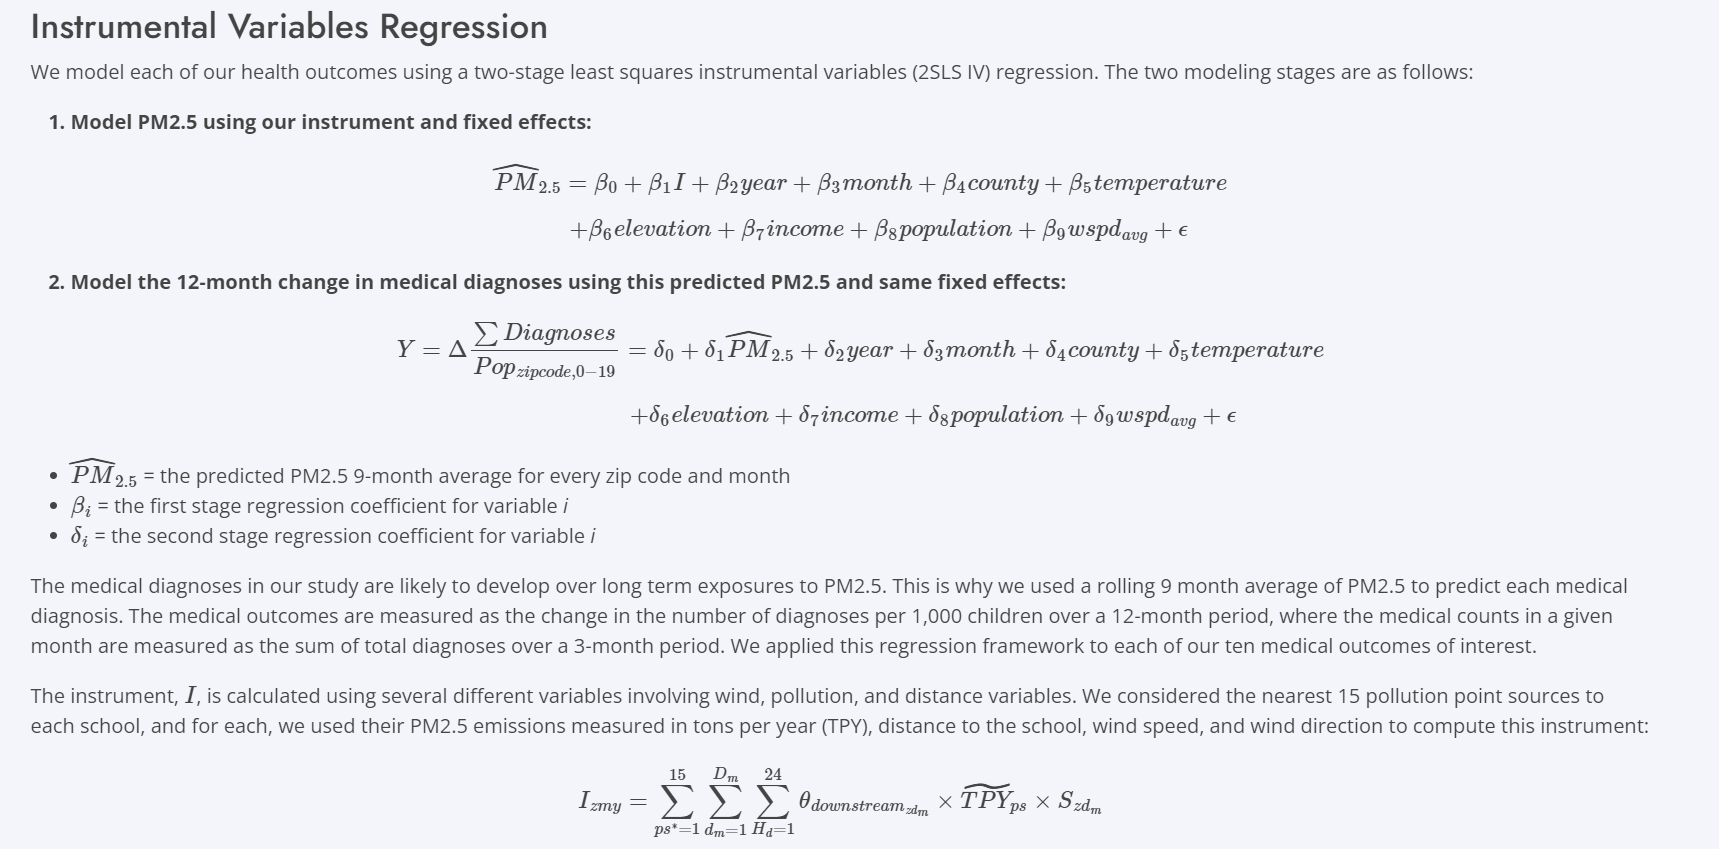

In [ ]:
###########################################
#Estimating the same model in statsmodel
#for confirmation of the result

y_dat = model_final['pm25']
x_dat = model_final[['intercept','instrument_2']]

stats_mod = sm.OLS(y_dat,x_dat)
sm_results = stats_mod.fit()
print(sm_results.summary())

#What is the mean squared error
pred = sm_results.get_prediction().summary_frame()
print( ((y_dat - pred['mean'])**2).sum() )
##########################################

                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2591.
Date:                Thu, 23 Mar 2023   Prob (F-statistic):               0.00
Time:                        19:06:48   Log-Likelihood:            -1.6366e+06
No. Observations:              509496   AIC:                         3.273e+06
Df Residuals:                  509494   BIC:                         3.273e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       10.0121      0.009   1151.324   

In [ ]:
'''
This creates all the functions to conduct
OLS with Deep Learning
Andy Wheeler
https://andrewpwheeler.com/
'''

import torch
import numpy as np
import pandas as pd
from scipy.stats import norm

#torch.manual_seed(0)

try:
    device = torch.device("cuda:0")
    text_dev = 'GPU'
except:
    print("Get on my level bro and get a GPU!")
    text_dev = 'CPU'
    device = torch.device("cpu")
    
#########################################
#Now setting up the regression model

#Defining different symbols for p-values
strong = '💪 yeah bro'
weak = '¯\_(ツ)_/¯'

def p_bro(p):
    if p < 0.05:
        return strong
    else:
        return weak
    
#This function takes the output from ols_deep
#And returns a nicer data frame of the results
def deep_table(model, var_cov, coef_names):
    cov_np = var_cov.detach().numpy()
    coef_np = model.coef.weight.detach().numpy()
    coef_np = coef_np.flatten()
    se_np = np.sqrt(np.diagonal(cov_np))
    dat_np = zip( list(coef_np), list(se_np) )
    pd_dat = pd.DataFrame(dat_np, columns=['Coefficients','Std-Error'],
                          index=coef_names)
    #Now making two tailed p-values
    t_vals = np.absolute( coef_np / se_np )
    p_vals = norm.cdf(-t_vals)*2
    pd_dat['p-values'] = p_vals
    pd_dat['Dude'] = pd_dat['p-values'].apply(p_bro)
    print(pd_dat)
    return pd_dat

class ols_torch(torch.nn.Module):
    def __init__(self, coef_n):
        """
        Construct parameters for the coefficients
        Need the intercept
        """
        super(ols_torch, self).__init__()
        self.coef = torch.nn.Linear(1, coef_n, bias=False)
        #setting the default weights for latent to equal prob
        #torch.nn.init.constant_(self.latent_flat, 1/float(groups))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        y_pred = torch.mm(x, self.coef.weight)
        #y_pred = self.coef(x)
        return y_pred
        
#Now making a function to take in the data (as pandas)
#And then return OLS coefficients, x should be the design
#matrix

def ols_deep(y,x,iterations=50000):
    #Set up a model object
    df = x.shape[1]
    model = ols_torch(coef_n = df)
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    #Now create the data tensors
    coef_names = list(x)
    x_ten = torch.tensor(x.to_numpy(), dtype=torch.float)
    y_ten = torch.tensor(pd.DataFrame(y).to_numpy(), dtype=torch.float)
    #Now iterating over the model
    for t in range(iterations):
        #Forward pass
        y_pred = model(x_ten)
        #Loss
        loss = criterion(y_pred, y_ten)
        if t % 1000 == 99:
            print(f'{text_dev} go brrrr, iteration {t} & loss is {loss.item()}')
        
        #Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #Now estimating the variance/covariance matrix of coefficients
    #Taken from https://www.reddit.com/r/statistics/comments/1vg8k0/standard_errors_in_glmnet/
    #To be fair, still doing in torch tensors
    n = x.shape[0]
    sigma_sq = loss.item() / (n - df)
    xpx = torch.mm(torch.transpose(x_ten, 0, 1),x_ten) 
    inv_xpx = torch.inverse(xpx)
    t1 = torch.mm(inv_xpx,xpx)
    t2 = torch.mm(t1,inv_xpx)
    var_cov = sigma_sq * t2
    print(f"\n Model Predicting {y.name} \n")
    pd_nicetab = deep_table(model, var_cov, coef_names)
    return model, var_cov, pd_nicetab
    

    


### Step 3: Define functions

### Step 4: Read data

## Wind

Wind load from other file

## Fire

Finsh cleaning some fire things and then join fire to wind 

In [ ]:
fire_df = pd.read_csv(in_instrument + "fire_wind_processed.csv", index_col=0)

# # Extract year and month, filter for fires in scope 1991+
# fire_df["year"] = fire_df["ALARM_DATE"].str[:4]
fire_df = fire_df[fire_df["year"].astype(int) > 1990]
fire_df = fire_df[fire_df["year"].astype(int) < 2020]

# Extract Month and End Year/Month
fire_df["month"] = fire_df["month"].astype(int)
fire_df["end_year"] = fire_df["CONT_DATE"].str[:4]
fire_df["end_month"] = fire_df["CONT_DATE"].str[5:7].astype(int)

# Give each fire a unique index code for later
fire_df = (
    fire_df.drop_duplicates().reset_index().rename(columns={"Index": "fire_index"})
)

fire_df["geometry"] = gpd.GeoSeries.from_wkt(fire_df["fire_centroid"])
fire_df["lon"] = fire_df["geometry"].apply(lambda p: p.x)
fire_df["lat"] = fire_df["geometry"].apply(lambda p: p.y)

fire_df["sq_mi"] = fire_df["GIS_ACRES"] / 640
fire_df["radius_mi"] = np.sqrt(fire_df["sq_mi"] / np.pi)

# Give each fire a unique index code for later
fire_df = (
    fire_df.drop_duplicates()
    .reset_index(drop=True)
    .reset_index()
    .rename(columns={"index": "fire_index"})
)

fire_dates = fire_df["year_month"].unique()
fire_indexes = fire_df.index

fire_df.year = fire_df.year.astype(int)
fire_df.month = fire_df.month.astype(int)
fire_df["max_days_in_mo"] = fire_df[["year", "month"]].apply(
    lambda x: calendar.monthrange(*x)[1], axis=1
)

fire_df["sq_mi"] = fire_df["GIS_ACRES"] / 640
fire_df["radius_mi"] = np.sqrt(fire_df["sq_mi"] / np.pi)

fire_df["start_month"] = fire_df["ALARM_DATE"].apply(lambda x: int(x[5:7]))
fire_df["start_day"] = fire_df["ALARM_DATE"].apply(lambda x: int(x[8:10]))

fire_df["end_month"] = fire_df["CONT_DATE"].apply(lambda x: int(x[5:7]))
fire_df["end_day"] = fire_df["CONT_DATE"].apply(lambda x: int(x[8:10]))


fire_df["start_mid_end"] = fire_df[["month", "start_month", "end_month"]].apply(
    lambda x: (
        "complete"
        if x[1] == x[2]
        else ("start" if x[0] == x[1] else ("end" if x[0] == x[2] else "mid"))
    ),
    axis=1,
)

fire_df["fire_days_in_mo"] = fire_df[
    [
        "start_month",
        "end_month",
        "max_days_in_mo",
        "start_day",
        "end_day",
        "start_mid_end",
    ]
].apply(
    lambda x: (
        1 if (x["end_day"] - x["start_day"] == 0) else (
            x["end_day"] - x["start_day"] if (
                x["start_mid_end"] == "complete") else (
                  x["max_days_in_mo"] - x["start_day"] if 
                  (x["start_mid_end"] == "start") else (
                      x["end_day"] if x["start_mid_end"] == "end" else (
                          x["max_days_in_mo"])))))/x["max_days_in_mo"],
    axis=1,
)

fire_backup = fire_df

fire_ready = fire_df[
    [
        "fire_lat_lon",
        "GIS_ACRES",
        "lat",
        "lon",
        "fire_days_in_mo",
        "fire_wdir",
        "fire_wspd",
        "year_month",
        'year',
        'month'
    ]
]
fire_ready = fire_ready\
    .reset_index(drop=True)\
    .rename(columns={'GIS_ACRES':'acres',
                     'lat':'fire_lat',
                     'lon':'fire_lon'})

fire_ready

,fire_lat_lon,acres,fire_lat,fire_lon,fire_days_in_mo,fire_wdir,fire_wspd,year_month,year,month
0,"(35.25539508507167, -119.5812970773511)",238.031830,35.255395,-119.581297,0.032258,342.554565,1.595909,199305,1993,5
1,"(39.45165114943642, -120.0093608630314)",19.139362,39.451651,-120.009361,0.032258,0.700786,1.000503,199307,1993,7
2,"(38.63102591471577, -120.8402934705149)",70.179840,38.631026,-120.840293,0.033333,58.361294,0.271346,199309,1993,9
3,"(35.42095813876129, -119.7656494555765)",23.423927,35.420958,-119.765649,0.033333,331.157288,1.023493,199309,1993,9
4,"(35.32190356232154, -118.4169237147862)",151.780167,35.321904,-118.416924,0.032258,7.345666,1.831764,199308,1993,8
...,...,...,...,...,...,...,...,...,...,...
6632,"(37.87494989081461, -119.7281350256987)",331.624695,37.874950,-119.728135,0.166667,73.448456,0.113857,200709,2007,9
6633,"(37.56860595616687, -119.6600328204804)",23.633701,37.568606,-119.660033,0.233333,158.267761,0.253292,200711,2007,11
6634,"(37.74854288820926, -119.7035432531625)",239.260773,37.748543,-119.703543,1.000000,215.334213,0.138538,200711,2007,11
6635,"(37.74854288820926, -119.7035432531625)",239.260773,37.748543,-119.703543,0.258065,178.254211,0.474964,200712,2007,12


In [ ]:
#Test cell
#fire_ready[fire_ready['fire_lat_lon'] == '(37.74854288820926, -119.7035432531625)']

In [ ]:
wind_ready

,lat,lon,ZCTA,u,v,wdir,wspd,year_month,year,month
0,37.465,-117.936,89010,0.504258,-0.719008,305.042938,0.878208,199101,1991,1
1,35.396,-116.322,89019,-0.172753,-0.946940,259.661102,0.962568,199101,1991,1
2,36.161,-116.139,89060,-0.435964,-0.812957,241.796738,0.922477,199101,1991,1
3,35.957,-115.897,89061,-0.560538,-1.176384,244.522552,1.303105,199101,1991,1
4,39.520,-120.032,89439,0.042253,0.205661,78.390099,0.209957,199101,1991,1
...,...,...,...,...,...,...,...,...,...,...
627067,39.149,-120.248,96146,0.636599,0.953782,56.279018,1.146716,202212,2022,12
627068,39.236,-120.062,96148,0.636599,0.953782,56.279018,1.146716,202212,2022,12
627069,38.732,-120.033,96150,0.071517,0.472164,81.387100,0.477549,202212,2022,12
627070,39.184,-120.427,96161,-0.217010,0.239125,132.224274,0.322915,202212,2022,12


## PM2.5

Load PM2.5 from lawis files downloaded from gdrive

In [ ]:
aqi1 = pd.read_csv(in_instrument + "jordan_firepm25.csv", index_col=0)
aqi2 = pd.read_csv(in_instrument + "finalpm25.csv", index_col=0)
aqi2

,year_month,ZIP10,pm25
204,2017-01,89010,1.842857
205,2017-02,89010,3.528571
206,2017-03,89010,3.242857
207,2017-04,89010,3.700000
208,2017-05,89010,5.242857
...,...,...,...
585307,2016-12,96148,1.713333
585308,2016-12,96150,1.719288
585309,2016-12,96155,0.771287
585310,2016-12,96161,1.416996


In [ ]:
pm25_df = aqi2.reset_index(drop=True).rename(
    columns={"ZIP10": "ZCTA", "year_month": "old_ym"}
)
pm25_df["year_month"] = pm25_df["old_ym"].str[:4] + pm25_df["old_ym"].str[5:]
pm25_df["ZCTA"] = pm25_df["ZCTA"].astype(str)
pm25_ready = pm25_df.drop("old_ym", axis=1)

In [ ]:
wfp_df = wind_ready.merge(pm25_ready,
                          on=["year_month", "ZCTA"],
                          how="left")
wind_final = wfp_df\
                .rename(columns={'lat':'zip_lat',
                'lon':'zip_lon',
                'wdir':'zip_wdir',
                'wspd':'zip_wspd',
                'pm25':'zip_pm25'})\
                .drop(['u','v'],axis=1)\
                [wfp_df['year'] < 2019]
wind_final.to_csv(in_instrument + 'wind_zip_pm25.csv')
wind_final

,zip_lat,zip_lon,ZCTA,zip_wdir,zip_wspd,year_month,year,month,zip_pm25
0,37.465,-117.936,89010,305.042938,0.878208,199101,1991,1,12.450976
1,35.396,-116.322,89019,259.661102,0.962568,199101,1991,1,10.846541
2,36.161,-116.139,89060,241.796738,0.922477,199101,1991,1,12.385000
3,35.957,-115.897,89061,244.522552,1.303105,199101,1991,1,10.150000
4,39.520,-120.032,89439,78.390099,0.209957,199101,1991,1,8.389565
...,...,...,...,...,...,...,...,...,...
548683,39.149,-120.248,96146,76.585587,0.437017,201812,2018,12,4.626316
548684,39.236,-120.062,96148,76.585587,0.437017,201812,2018,12,4.528572
548685,38.732,-120.033,96150,107.369316,0.231856,201812,2018,12,4.286667
548686,39.184,-120.427,96161,151.071350,0.243283,201812,2018,12,5.053509


In [ ]:
fire_pm25 = aqi1.rename(columns={
                      'lat':'fire_lat',
                      'lon':'fire_lon',
                      'pm25':'fire_pm25'})\
                .reset_index(drop=True)
fire_pm25.to_csv('fire_pm25.csv')
fire_pm25

,year,month,fire_lat,fire_lon,fire_pm25
0,1991,1,39.155351,-122.775965,0.10
1,1991,1,39.567560,-121.002336,11.24
2,1991,1,39.084997,-122.744482,1.74
3,1991,1,39.756806,-121.331523,10.59
4,1991,1,39.694403,-121.355888,15.02
...,...,...,...,...,...
8267,2016,11,40.375938,-120.751081,3.61
8268,2016,12,34.047386,-118.948054,4.52
8269,2016,12,34.234554,-118.800483,5.81
8270,2016,12,34.122593,-118.722263,6.09


In [ ]:
aqi1.drop_duplicates()

,year,month,lat,lon,pm25
1341,1991,1,39.155351,-122.775965,0.10
1896,1991,1,39.567560,-121.002336,11.24
2600,1991,1,39.084997,-122.744482,1.74
2772,1991,1,39.756806,-121.331523,10.59
2773,1991,1,39.694403,-121.355888,15.02
...,...,...,...,...,...
9274,2016,11,40.375938,-120.751081,3.61
2222,2016,12,34.047386,-118.948054,4.52
2241,2016,12,34.234554,-118.800483,5.81
6805,2016,12,34.122593,-118.722263,6.09


In [ ]:
fire_ready

,fire_lat_lon,acres,fire_lat,fire_lon,fire_days_in_mo,fire_wdir,fire_wspd,year_month,year,month
0,"(35.25539508507167, -119.5812970773511)",238.031830,35.255395,-119.581297,0.032258,342.554565,1.595909,199305,1993,5
1,"(39.45165114943642, -120.0093608630314)",19.139362,39.451651,-120.009361,0.032258,0.700786,1.000503,199307,1993,7
2,"(38.63102591471577, -120.8402934705149)",70.179840,38.631026,-120.840293,0.033333,58.361294,0.271346,199309,1993,9
3,"(35.42095813876129, -119.7656494555765)",23.423927,35.420958,-119.765649,0.033333,331.157288,1.023493,199309,1993,9
4,"(35.32190356232154, -118.4169237147862)",151.780167,35.321904,-118.416924,0.032258,7.345666,1.831764,199308,1993,8
...,...,...,...,...,...,...,...,...,...,...
6632,"(37.87494989081461, -119.7281350256987)",331.624695,37.874950,-119.728135,0.166667,73.448456,0.113857,200709,2007,9
6633,"(37.56860595616687, -119.6600328204804)",23.633701,37.568606,-119.660033,0.233333,158.267761,0.253292,200711,2007,11
6634,"(37.74854288820926, -119.7035432531625)",239.260773,37.748543,-119.703543,1.000000,215.334213,0.138538,200711,2007,11
6635,"(37.74854288820926, -119.7035432531625)",239.260773,37.748543,-119.703543,0.258065,178.254211,0.474964,200712,2007,12


In [ ]:
fire_final = fire_ready.merge(fire_pm25, on=['fire_lat','fire_lon','year','month'], how='left').drop_duplicates().reset_index(drop=True)
fire_final

,fire_lat_lon,acres,fire_lat,fire_lon,fire_days_in_mo,fire_wdir,fire_wspd,year_month,year,month,fire_pm25
0,"(35.25539508507167, -119.5812970773511)",238.031830,35.255395,-119.581297,0.032258,342.554565,1.595909,199305,1993,5,9.38
1,"(39.45165114943642, -120.0093608630314)",19.139362,39.451651,-120.009361,0.032258,0.700786,1.000503,199307,1993,7,5.53
2,"(38.63102591471577, -120.8402934705149)",70.179840,38.631026,-120.840293,0.033333,58.361294,0.271346,199309,1993,9,14.24
3,"(35.42095813876129, -119.7656494555765)",23.423927,35.420958,-119.765649,0.033333,331.157288,1.023493,199309,1993,9,11.99
4,"(35.32190356232154, -118.4169237147862)",151.780167,35.321904,-118.416924,0.032258,7.345666,1.831764,199308,1993,8,9.19
...,...,...,...,...,...,...,...,...,...,...,...
6632,"(37.87494989081461, -119.7281350256987)",331.624695,37.874950,-119.728135,0.166667,73.448456,0.113857,200709,2007,9,4.76
6633,"(37.56860595616687, -119.6600328204804)",23.633701,37.568606,-119.660033,0.233333,158.267761,0.253292,200711,2007,11,4.38
6634,"(37.74854288820926, -119.7035432531625)",239.260773,37.748543,-119.703543,1.000000,215.334213,0.138538,200711,2007,11,1.70
6635,"(37.74854288820926, -119.7035432531625)",239.260773,37.748543,-119.703543,0.258065,178.254211,0.474964,200712,2007,12,3.80


In [ ]:
def distance(wind, fire):
    """
    params:
    -------
    wind: wind cleaned data
    fire: fire semi-cleaned data

    return:
    -------
    df3: dataframe with distances from each fire during time period
    """
    # create labels
    wind["wind_lat_lon"] = [str(xy) for xy in zip(wind.zip_lat, wind.zip_lon)]
    fire["fire_lat_lon"] = [str(xy) for xy in zip(fire.fire_lat, fire.fire_lon)]

    ## for each point in wind data find the nearest point in the census data ##
    ###############
    # keep only unique points in fire data
    df1_unique = wind.drop_duplicates(["wind_lat_lon"])
    df2_unique = fire.drop_duplicates(["fire_lat_lon"])

    df1_unique.reset_index(drop=True, inplace=True)
    df2_unique.reset_index(drop=True, inplace=True)

    # transform to radians
    df1_unique["lat_r"] = np.radians(df1_unique.zip_lat)
    df1_unique["lon_r"] = np.radians(df1_unique.zip_lon)
    df2_unique["lat_r"] = np.radians(df2_unique.fire_lat)
    df2_unique["lon_r"] = np.radians(df2_unique.fire_lon)

    # compute pairwise distance (in miles)
    dist_matrix = (
        dist.pairwise(
            df2_unique[["lat_r", "lon_r"]],
            df1_unique[["lat_r", "lon_r"]],
        )
    ) * 3959

    # create a df from dist_matrix
    dist_matrix = pd.DataFrame(
        dist_matrix, index=df2_unique["fire_lat_lon"], columns=df1_unique["ZCTA"]
    )
    return dist_matrix

In [ ]:
temp_df = distance(wind_final, fire_final)
dist_df = fire_final.merge(
    temp_df,
    left_on="fire_lat_lon",
    right_on=temp_df.index,
    how='left'
).drop_duplicates().reset_index(drop=True)
dist_df

,fire_lat_lon,acres,fire_lat,fire_lon,fire_days_in_mo,fire_wdir,fire_wspd,year_month,year,month,...,96140,96141,96142,96143,96145,96146,96148,96150,96161,97635
0,"(35.25539508507167, -119.5812970773511)",238.031830,35.255395,-119.581297,0.032258,342.554565,1.595909,199305,1993,5,...,273.902165,262.986709,255.763437,275.094422,265.225259,271.526768,276.316781,241.513929,275.412483,466.944962
1,"(39.45165114943642, -120.0093608630314)",19.139362,39.451651,-120.009361,0.032258,0.700786,1.000503,199307,1993,7,...,18.155774,30.531542,36.890962,15.868377,29.049318,24.497956,15.164144,49.742314,28.990727,176.052420
2,"(38.63102591471577, -120.8402934705149)",70.179840,38.631026,-120.840293,0.033333,58.361294,0.271346,199309,1993,9,...,55.923517,44.852443,42.502675,60.493373,45.091172,47.913347,59.138386,44.100498,44.201396,234.375215
3,"(35.42095813876129, -119.7656494555765)",23.423927,35.420958,-119.765649,0.033333,331.157288,1.023493,199309,1993,9,...,261.622226,250.503922,243.318349,262.985454,252.701931,258.958683,264.112075,229.258884,262.543176,454.860185
4,"(35.32190356232154, -118.4169237147862)",151.780167,35.321904,-118.416924,0.032258,7.345666,1.831764,199308,1993,8,...,283.319934,274.116537,266.888233,283.351792,276.555557,282.960181,285.162251,251.917314,288.832200,471.414260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6632,"(37.87494989081461, -119.7281350256987)",331.624695,37.874950,-119.728135,0.166667,73.448456,0.113857,200709,2007,9,...,93.579473,83.601955,76.330517,94.315845,85.999136,92.411551,95.759703,61.483932,98.022876,285.885768
6633,"(37.56860595616687, -119.6600328204804)",23.633701,37.568606,-119.660033,0.233333,158.267761,0.253292,200711,2007,11,...,115.058673,104.965884,97.687268,115.806581,107.344223,113.752581,117.250544,82.902744,119.099573,307.313468
6634,"(37.74854288820926, -119.7035432531625)",239.260773,37.748543,-119.703543,1.000000,215.334213,0.138538,200711,2007,11,...,102.401609,92.355699,85.079677,103.152564,94.742784,101.153523,104.591706,70.267223,106.628801,294.707998
6635,"(37.74854288820926, -119.7035432531625)",239.260773,37.748543,-119.703543,0.258065,178.254211,0.474964,200712,2007,12,...,102.401609,92.355699,85.079677,103.152564,94.742784,101.153523,104.591706,70.267223,106.628801,294.707998


In [ ]:
dist_df

,fire_lat_lon,acres,fire_lat,fire_lon,fire_days_in_mo,fire_wdir,fire_wspd,year_month,year,month,...,96140,96141,96142,96143,96145,96146,96148,96150,96161,97635
0,"(35.25539508507167, -119.5812970773511)",238.031830,35.255395,-119.581297,0.032258,342.554565,1.595909,199305,1993,5,...,273.902165,262.986709,255.763437,275.094422,265.225259,271.526768,276.316781,241.513929,275.412483,466.944962
1,"(39.45165114943642, -120.0093608630314)",19.139362,39.451651,-120.009361,0.032258,0.700786,1.000503,199307,1993,7,...,18.155774,30.531542,36.890962,15.868377,29.049318,24.497956,15.164144,49.742314,28.990727,176.052420
2,"(38.63102591471577, -120.8402934705149)",70.179840,38.631026,-120.840293,0.033333,58.361294,0.271346,199309,1993,9,...,55.923517,44.852443,42.502675,60.493373,45.091172,47.913347,59.138386,44.100498,44.201396,234.375215
3,"(35.42095813876129, -119.7656494555765)",23.423927,35.420958,-119.765649,0.033333,331.157288,1.023493,199309,1993,9,...,261.622226,250.503922,243.318349,262.985454,252.701931,258.958683,264.112075,229.258884,262.543176,454.860185
4,"(35.32190356232154, -118.4169237147862)",151.780167,35.321904,-118.416924,0.032258,7.345666,1.831764,199308,1993,8,...,283.319934,274.116537,266.888233,283.351792,276.555557,282.960181,285.162251,251.917314,288.832200,471.414260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6632,"(37.87494989081461, -119.7281350256987)",331.624695,37.874950,-119.728135,0.166667,73.448456,0.113857,200709,2007,9,...,93.579473,83.601955,76.330517,94.315845,85.999136,92.411551,95.759703,61.483932,98.022876,285.885768
6633,"(37.56860595616687, -119.6600328204804)",23.633701,37.568606,-119.660033,0.233333,158.267761,0.253292,200711,2007,11,...,115.058673,104.965884,97.687268,115.806581,107.344223,113.752581,117.250544,82.902744,119.099573,307.313468
6634,"(37.74854288820926, -119.7035432531625)",239.260773,37.748543,-119.703543,1.000000,215.334213,0.138538,200711,2007,11,...,102.401609,92.355699,85.079677,103.152564,94.742784,101.153523,104.591706,70.267223,106.628801,294.707998
6635,"(37.74854288820926, -119.7035432531625)",239.260773,37.748543,-119.703543,0.258065,178.254211,0.474964,200712,2007,12,...,102.401609,92.355699,85.079677,103.152564,94.742784,101.153523,104.591706,70.267223,106.628801,294.707998


In [ ]:
def fire_bearings(wind, fire):
    """
    params:
    -------
    wind: wind cleaned data
    fire: fire semi-cleaned data

    return:
    -------
    df3: dataframe with distances from each fire during time period
    """

    ## for each point in wind data find the angle##
    ###############
    # keep only unique points in fire data
    df1_unique = wind.drop_duplicates(["wind_lat_lon"])
    df2_unique = fire.drop_duplicates(["fire_lat_lon"])

    df1_unique.reset_index(drop=True, inplace=True)
    df2_unique.reset_index(drop=True, inplace=True)

    # transform to radians
    df1_unique["lat_r"] = np.radians(df1_unique.zip_lat)
    df1_unique["lon_r"] = np.radians(df1_unique.zip_lon)
    df2_unique["lat_r"] = np.radians(df2_unique.fire_lat)
    df2_unique["lon_r"] = np.radians(df2_unique.fire_lon)


    # compute pairwise distance (in miles)
    bearing_matrix = np.zeros((df1_unique.shape[0], df2_unique.shape[0]))
    for idx in range(df1_unique.shape[0]):
        pa_lat = df1_unique["zip_lat"][idx]
        pa_lon = df1_unique["zip_lon"][idx]
        wdir_ba = df2_unique["fire_wdir"][idx]
        for idy in range(df2_unique.shape[0]):
            pb_lat = df2_unique["fire_lat"][idy]
            pb_lon = df2_unique["fire_lon"][idy]

            if pb_lon > pa_lon:
                d_X = -np.cos(pa_lat) * np.sin(pa_lon - pb_lon)
            else:
                d_X = np.cos(pa_lat) * np.sin(pa_lon - pb_lon)

            if pb_lat > pa_lat:
                d_Y = -np.cos(pb_lat) * np.sin(pa_lat) - np.sin(pb_lat) * np.cos(
                    pa_lat
                ) * np.cos(pa_lon - pb_lon)
            else:
                d_Y = np.cos(pb_lat) * np.sin(pa_lat) - np.sin(pb_lat) * np.cos(
                    pa_lat
                ) * np.cos(pa_lon - pb_lon)

            B_ba = np.arctan2(d_X, d_Y) * (180 / np.pi) % 360

            angle_diff = np.max([B_ba, wdir_ba]) - np.min([B_ba, wdir_ba])

            if angle_diff > 180:
                upwind_effect = (angle_diff) / 360
            else:
                upwind_effect = 1 - (angle_diff) / 360

            bearing_matrix[idx, idy] = upwind_effect

    # create a df from dist_matrix
    bearing_matrix = pd.DataFrame(
        bearing_matrix, index=df1_unique["ZCTA"], columns=df2_unique["fire_lat_lon"]
    )

    return bearing_matrix

In [ ]:
temp_df = fire_bearings(wind_final, fire_final)


In [ ]:
temp_df = temp_df.fillna(0)
merge_temp_df = temp_df.T
bearings = fire_ready.merge(
    merge_temp_df,
    left_on='fire_lat_lon',
    right_on=merge_temp_df.index,
    how='left'
)
bearings.head(2)

,fire_lat_lon,acres,fire_lat,fire_lon,fire_days_in_mo,fire_wdir,fire_wspd,year_month,year,month,...,96140,96141,96142,96143,96145,96146,96148,96150,96161,97635
0,"(35.25539508507167, -119.5812970773511)",238.031830,35.255395,-119.581297,0.032258,342.554565,1.595909,199305,1993,5,...,0.529931,0.598269,0.662514,0.532863,0.622019,0.637264,0.616758,0.521091,0.613033,0.826084
1,"(39.45165114943642, -120.0093608630314)",19.139362,39.451651,-120.009361,0.032258,0.700786,1.000503,199307,1993,7,...,0.953073,0.528072,0.658048,0.962805,0.761105,0.946191,0.888510,0.603677,0.952879,0.873414


In [ ]:
bearings_fire = bearings
bearings_fire.head()

,fire_lat_lon,acres,fire_lat,fire_lon,fire_days_in_mo,fire_wdir,fire_wspd,year_month,year,month,...,96140,96141,96142,96143,96145,96146,96148,96150,96161,97635
0,"(35.25539508507167, -119.5812970773511)",238.031830,35.255395,-119.581297,0.032258,342.554565,1.595909,199305,1993,5,...,0.529931,0.598269,0.662514,0.532863,0.622019,0.637264,0.616758,0.521091,0.613033,0.826084
1,"(39.45165114943642, -120.0093608630314)",19.139362,39.451651,-120.009361,0.032258,0.700786,1.000503,199307,1993,7,...,0.953073,0.528072,0.658048,0.962805,0.761105,0.946191,0.888510,0.603677,0.952879,0.873414
2,"(38.63102591471577, -120.8402934705149)",70.179840,38.631026,-120.840293,0.033333,58.361294,0.271346,199309,1993,9,...,0.948314,0.816085,0.974584,0.952978,0.950189,0.900464,0.893150,0.728573,0.911306,0.510884
3,"(35.42095813876129, -119.7656494555765)",23.423927,35.420958,-119.765649,0.033333,331.157288,1.023493,199309,1993,9,...,0.531475,0.599915,0.662499,0.534155,0.620580,0.636103,0.615938,0.507633,0.613045,0.816083
4,"(35.32190356232154, -118.4169237147862)",151.780167,35.321904,-118.416924,0.032258,7.345666,1.831764,199308,1993,8,...,0.522109,0.583436,0.679973,0.526616,0.634721,0.645291,0.620852,0.501348,0.615551,0.822699


In [ ]:
treatment_df = (bearings_fire.drop_duplicates().iloc[:, 11:] >= 0.75)[
    dist_df.drop_duplicates().iloc[:, 11:] < 200
].fillna(False) 

treatment_df["fire_lat_lon"] = (
    bearings.drop_duplicates()["fire_lat_lon"].astype(str)
)
treatment_df["year_month"] = bearings_fire.drop_duplicates()["year_month"]
treatment_df["fire_wdir"] = bearings_fire.drop_duplicates()["fire_wdir"]
treatment_df["fire_wspd"] = bearings_fire.drop_duplicates()["fire_wspd"]

treatment_df["fire_days_in_mo"] = bearings_fire.drop_duplicates()["fire_days_in_mo"]
treatment_df = treatment_df.reset_index(drop=True)

In [ ]:
fire_bear = bearings_fire[(bearings_fire.drop_duplicates().iloc[:, 11:] >= 0.75)[
    dist_df.drop_duplicates().iloc[:, 11:] < 200
]].fillna(0) 

fire_bear["fire_lat_lon"] = (
    bearings.drop_duplicates()["fire_lat_lon"].astype(str)
)
fire_bear["year_month"] = bearings_fire.drop_duplicates()["year_month"]
fire_bear["fire_wdir"] = bearings_fire.drop_duplicates()["fire_wdir"]
fire_bear["fire_wspd"] = bearings_fire.drop_duplicates()["fire_wspd"]

fire_bear["fire_days_in_mo"] = bearings_fire.drop_duplicates()["fire_days_in_mo"]
fire_bear = fire_bear.reset_index(drop=True)

fire_bear.to_csv('fire_bear.csv')

In [ ]:
fire_dist = dist_df[(bearings_fire.drop_duplicates().iloc[:, 11:] >= 0.75)[
    dist_df.drop_duplicates().iloc[:, 11:] < 200
]].fillna(0) 

fire_dist["fire_lat_lon"] = (
    bearings.drop_duplicates()["fire_lat_lon"].astype(str)
)
fire_dist["year_month"] = bearings_fire.drop_duplicates()["year_month"]
fire_dist["fire_wdir"] = bearings_fire.drop_duplicates()["fire_wdir"]
fire_dist["fire_wspd"] = bearings_fire.drop_duplicates()["fire_wspd"]

fire_dist["fire_days_in_mo"] = bearings_fire.drop_duplicates()["fire_days_in_mo"]
fire_dist = fire_dist.reset_index(drop=True)

fire_dist.to_csv('fire_dist.csv')

In [ ]:
days_mo = fire_dist['fire_days_in_mo'][2]
wspd = fire_dist['fire_wspd'][2]
distance = fire_dist['96142'][2]
bearing = fire_bear['96142'][2]

instrument = np.sum(days_mo * wspd * distance * bearing)
instrument

0.3746602309176257

In [ ]:
from tqdm import tqdm

In [ ]:
def get_instrument(distance_df,bearing_df):
  instrument_df = pd.DataFrame(columns = ['ZCTA','fire_lat_lon','instrument','year_month'])
  for ym in tqdm(distance_df.index):
    days_mo = distance_df['fire_days_in_mo'][ym]
    wspd = distance_df['fire_wspd'][ym]
    #fire_pm25 = bearing_df[]
    for zcta in distance_df.columns[11:]:
      if distance_df.loc[ym,zcta] ==0:
        pass
      else:
        distance = distance_df[zcta][ym]
        bearing = bearing_df[zcta][ym]
        instrument = days_mo * wspd * distance * bearing
        instrument_df = instrument_df.append({'ZCTA':zcta,
                             'fire_lat_lon': distance_df['fire_lat_lon'][ym],
                             'instrument': instrument,
                             'year_month': distance_df['year_month'][ym]},ignore_index=True)

  return instrument_df


In [ ]:
in_instrument

'/content/drive/MyDrive/capstone_fire/notebooks/instrument_2/'

In [ ]:
ins_df = get_instrument(fire_dist, fire_bear)
ins_df.to_csv(in_instrument+'instrument_df.csv')

 62%|██████▏   | 4122/6637 [16:10:55<9:52:24, 14.13s/it] 


KeyboardInterrupt: ignored

In [ ]:
ins_df

,ZCTA,fire_lat_lon,instrument,year_month


In [ ]:
wind_final

,zip_lat,zip_lon,ZCTA,zip_wdir,zip_wspd,year_month,year,month,zip_pm25,wind_lat_lon
0,37.465,-117.936,89010,305.042938,0.878208,199101,1991,1,12.450976,"(37.465, -117.936)"
1,35.396,-116.322,89019,259.661102,0.962568,199101,1991,1,10.846541,"(35.396, -116.322)"
2,36.161,-116.139,89060,241.796738,0.922477,199101,1991,1,12.385000,"(36.161, -116.139)"
3,35.957,-115.897,89061,244.522552,1.303105,199101,1991,1,10.150000,"(35.957, -115.897)"
4,39.520,-120.032,89439,78.390099,0.209957,199101,1991,1,8.389565,"(39.52, -120.032)"
...,...,...,...,...,...,...,...,...,...,...
548683,39.149,-120.248,96146,76.585587,0.437017,201812,2018,12,4.626316,"(39.149, -120.248)"
548684,39.236,-120.062,96148,76.585587,0.437017,201812,2018,12,4.528572,"(39.236, -120.062)"
548685,38.732,-120.033,96150,107.369316,0.231856,201812,2018,12,4.286667,"(38.732, -120.033)"
548686,39.184,-120.427,96161,151.071350,0.243283,201812,2018,12,5.053509,"(39.184, -120.427)"


In [ ]:
df["fire_index"] = fire_indexes

In [ ]:
impacted = dict()
for fire in treatment_df.iterrows():
    impacted[treatment_df.iloc[fire[0], -2]] = wind_zips[
        np.asarray(fire[1][:-2], dtype=bool)
    ]

# Data stored in the impacted dictionary uses the fire_index as the key vs the index of the dataframe which was used for checking

# impacted

treatment_df.sum(axis=1)
# for zcta in wind_zips[fire[1]]:
#     impacted[fire[0]].append(zcta)

In [ ]:
treatment_df.iloc[:, :-2].sum(axis=0)

In [ ]:
treatment_df.iloc[7249, :]

In [ ]:
len(impacted["18167"])

In [ ]:
x = treatment_df.iloc[7249, :-2]
# impacted[fire[0]] = []
# for zcta in wind_zips[fire[1]]:
#     impacted[fire[0]].append(zcta)

mask = [i for i in x]
len(wind_zips[mask])

In [ ]:
bear_export = bearings.drop_duplicates()
bear_export.to_csv("bearings_new.csv")

In [ ]:
dist_export = dist_df.drop_duplicates()
dist_export.to_csv("dist_new.csv")

In [ ]:
dist_matrix = pd.read_csv("dist_new.csv", index_col=0)
bear_matrix = pd.read_csv("bearings_new.csv", index_col=0)

In [ ]:
pm25_ready

In [ ]:
dist_matrix

In [ ]:
# initialize empty lists
fires = []
impacted_zips = []
zip_distances = []
winds = []
zip_bearings = []

In [ ]:
small_dist = dist_df
small_dist.fire_index = small_dist.fire_index.astype(int)
small_dist.year_month = small_dist.year_month.astype(int)
small_dist = small_dist.set_index(["fire_index", "year_month"])

small_bear = bearings
small_bear.fire_index = small_bear.fire_index.astype(int)
small_bear.year_month = small_bear.year_month.astype(int)
small_bear = small_bear.set_index(["fire_index", "year_month"])

In [ ]:
small_dist.loc[small_dist.index[0], :]

In [ ]:
import pandas as pd

In [ ]:
small_dist.loc[small_dist.index[0]][small_dist.loc[fire_id] < 100]

In [ ]:
for i in small_dist.index:
    fire_id = i
    # return zip and distance data for relevant ZCTAs
    tmp = small_dist.loc[fire_id][small_dist.loc[fire_id] < 100]
    # add data to list
    impacted_zips += list(tmp.index)
    zip_distances += list(tmp.values)
    fires += [fire_id] * tmp.shape[0]
    winds += list(
        small_bear.loc[
            fire_id, list(wind_zips[np.asarray(~tmp.isna()[:-2], dtype=bool)])
        ].values
    )

In [ ]:
small_dist.loc[(0, 202006), :]

In [ ]:
wind_locs

In [ ]:
fire_impact_df = pd.DataFrame(
    {
        "fire_num": fires,
        "impacted_zip": impacted_zips,
        "zip_dist": zip_distances,
        "wind": winds,
    }
)

In [ ]:
model_df = fire_4d.drop(columns=["lat", "lon", "u", "v", "wind_lat_lon"])
model_df = model_df.drop(model_df[model_df["year"] > 2019].index)
model_df = model_df.drop(columns=["year", "month"])
model_df["fire_index"] = model_df["fire_index"].fillna(-1)
model_df["radius_mi"] = model_df["radius_mi"].fillna(-1)
model_df["treatment"] = model_df["treatment"].fillna(False)
model_df.fire_index = model_df.fire_index.astype(int)
model_df.fire_index = model_df.fire_index.astype(str)
model_df = model_df.drop_duplicates()
model_df["real_interaction"] = np.nan
model_df["real_distance"] = np.nan
model_df["interaction"] = np.nan
model_df["distance"] = np.nan
model_df["duration_days"] = model_df["duration_days"].fillna(-1)
model_df.groupby(["ZCTA", "year_month", "fire_index"]).first()
model_df

In [ ]:
model_df.to_csv("progress.csv")

In [ ]:
bearings.T.head()

In [ ]:
fire_later = (
    fire_indexed.merge(bearings.T, on="fire_index", how="left")
    .fillna(0)
    .drop_duplicates()
)

fire_later.columns = fire_later.columns.astype(str)
fire_later.fire_index = fire_later.fire_index.astype(int)
fire_later.fire_index = fire_later.fire_index.astype(str)
fire_later = fire_later.set_index(["fire_index", "year_month", "ZCTA"])

fire_later.head()

In [ ]:
fire_later2 = (
    fire_indexed.merge(dist_df.T, on="fire_index", how="left")
    .fillna(0)
    .drop_duplicates()
)
fire_later2.columns = fire_later2.columns.astype(str)
fire_later2.fire_index = fire_later2.fire_index.astype(int)
fire_later2.fire_index = fire_later2.fire_index.astype(str)
fire_later2 = fire_later2.set_index(["fire_index", "year_month", "ZCTA"])

fire_later2

In [ ]:
dist_df = dist_df.fillna(0)

In [ ]:
dist_df.head()

In [ ]:
dist_df.loc[89010, :]

In [ ]:
model_df.ZCTA = model_df.ZCTA.astype(str)
model_df.fire_index = model_df.fire_index.astype(str)
model_df.year_month = model_df.year_month.astype(str)

model_df2 = model_df.set_index(["fire_index", "year_month", "ZCTA"]).drop_duplicates()

In [ ]:
# errors = []
# for entry in model_df2.iterrows():
#     if entry[0][0] == "-1":
#         model_df2.loc[(entry[0]), "real_interaction"] = 0
#         model_df2.loc[(entry[0]), "real_distance"] = 0

#     elif (
#         entry[0][2] in fire_later.columns
#         and entry[0][2] in fire_later2.columns
#         and entry[0] in fire_later.index
#         and entry[0] in fire_later2.index
#     ):
#         try:
#             model_df2.loc[entry[0], "real_interaction"] = fire_later.loc[
#                 entry[0], entry[0][2]
#             ]
#             model_df2.loc[entry[0], "real_distance"] = fire_later2.loc[
#                 entry[0], entry[0][2]
#             ]
#         except:
#             errors.append(entry)
#             continue
#     # else:
#     #     model_df2.loc[entry[0], "real_interaction"] = 0
#     #     model_df2.loc[entry[0], "real_distance"] = -1

In [ ]:
errors = []
for entry in model_df2.head().iterrows():
    print(entry[0][2])
    if entry[0][0] == "-1":
        model_df2.loc[(entry[0]), "real_interaction"] = 0
        model_df2.loc[(entry[0]), "real_distance"] = 0

    else:
        try:
            model_df2.loc[entry[0], "real_interaction"] = bearings.loc[
                int(entry[0][2]), entry[0][0]
            ]
            model_df2.loc[entry[0], "real_distance"] = dist_df.loc[
                int(entry[0][2]), entry[0][0]
            ]
        except:
            errors.append(entry)
            continue

In [ ]:
errors[0][0]

In [ ]:
dist_df.head()

In [ ]:
dist_df.loc[int(errors[0][0][2]), errors[0][0][0]]

In [ ]:
bearings.loc[int(errors[0][0][2]), errors[0][0][0]]

In [ ]:
model_df2.loc[

###### model_df2.to_csv("instrument2b_with_int_and_dist.csv")

In [ ]:
# model_df2 = pd.read_csv("instrument2b_with_int_and_dist.csv", index_col=[0, 1, 2])
# model_df2

In [ ]:
def ins_interaction(df):
    if df["real_interaction"] >= 0.75 and df["real_distance"] <= 100:
        return df["real_interaction"]
    else:
        return 0


def ins_distance(df):
    if df["real_interaction"] >= 0.75 and df["real_distance"] <= 100:
        return df["real_distance"]
    else:
        return 0


def ins_treatment(df):
    if df["real_interaction"] >= 0.75 and df["real_distance"] <= 100:
        return True
    else:
        return False

In [ ]:
model_df2.real_distance.max()

In [ ]:
model_df2["distance"] = model_df2.apply(ins_distance, axis=1)

In [ ]:
model_df2["interaction"] = model_df2.apply(ins_interaction, axis=1)

In [ ]:
model_df2["treatment"] = model_df2.apply(ins_treatment, axis=1)

In [ ]:
model_df2

In [ ]:
elevation = pd.read_csv("all_elevations.csv")

In [ ]:
elev_df = pd.read_csv("all_elevations.csv")
elev_df["temp"] = elev_df["elevation"].apply(lambda x: int(x[: (len(x) - 3)]))
elev_df = elev_df.drop("elevation", axis=1)
elev_df = elev_df.rename(columns={"zips": "ZCTA", "temp": "elevation"})
elev_df["ZCTA"] = elev_df["ZCTA"].astype(str)
elev_df

In [ ]:
model_df3 = model_df2.reset_index()

In [ ]:
model_final = model_df3.merge(elev_df, on="ZCTA", how="left")
model_final["year"] = model_final["year_month"].apply(lambda x: str(x[:4]))
model_final

In [ ]:
model_final.to_csv("wind-fire-pm-elev-ins.csv")

In [ ]:
model_final.real_distance.max()

In [ ]:
model_df2.to_csv("modeling_data_int_days_rad.csv")

In [ ]:
np.sum(~model_df2["treatment"])

In [ ]:
model_df2.real_distance.max()

In [ ]:
np.sum(model_df2.distance.isna())

In [ ]:
model_df2.real_distance

In [ ]:
np.sum(model_df2.real_distance.isna())

In [ ]:
bearings.to_csv("bearings.csv")

In [ ]:
bearings

In [ ]:
dist_df.to_csv("dist.csv")

In [ ]:
errors

In [ ]:
dist_df

In [ ]:
model_df2.real_distance.max()

In [ ]:
model_df2 = pd.read_csv("instrument2b_with_int_and_dist.csv", index_col=[0, 1, 2])

In [ ]:
model_df2.to_csv("instrument1_with_val_tuesday.csv")

In [ ]:
model_df2.distance.max()

In [ ]:
model_df2 = pd.read_csv("instrument2b_with_int_and_dist.csv", index_col=[0, 1, 2])
try:
    model_df2 = model_df2.drop((4126, 200508, 97635), axis=0)
    model_df2["treatment_2"] = np.where(model_df2["distance"] > 0, True, False)
    print("success")
except:
    pass